# 2 практическое задание. Сегментация изображений.

## Практикум на ЭВМ для 317 группы, весна 2019

#### Фамилия, имя: Находнов Максим

Дата выдачи: 21 марта

Мягкий дедлайн: 02 марта 06:00 

В этом задании вы будете решать задачу сегментации людей на фотографии с помощью нейросетевых архитектур Unet и Linknet.

## Загрузка данных (1 балл)

Для загрузки данных pytorch опирается на такую сущность, как **`Dataset`**.

Этот абстрактный класс определен в `torch.utils.data.dataset`:

```python
class Dataset(object):
    """An abstract class representing a Dataset.

    All other datasets should subclass it. All subclasses should override
    ``__len__``, that provides the size of the dataset, and ``__getitem__``,
    supporting integer indexing in range from 0 to len(self) exclusive.
    """

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self, other])
```
При определении нового источника данных мы создаем наследника данного класса и реализуем методы `__getitem__` и `__len__`.

Пример готового такого класса — `torchvision.datasets.ImageFolder`, который позволяет создать датасет на основе директории с imagenet-подобной структурой поддиректорий (`./train/{class}` и `./val/{class}`):

```python
imagenet = torchvision.datasets.ImageFolder('path/to/imagenet_root/')
```

Реализуйте класс PhotosDataset для выданных данных.

**Внимание.** Возможно, стоит прочитать следующий пункт задания, чтобы реализация была удобной.

In [1]:
!pip install scikit-image --user

In [2]:
import os

import PIL
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision

import pandas as pd

import numpy as np
import numpy.testing as npt

from skimage import io

import matplotlib.pyplot as plt

import time

In [3]:
class PhotosDataset(Dataset):
    
    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'training.pt'
    test_file = 'test.pt'

    @property
    def targets(self):
        if self.train:
            return self.train_labels
        else:
            return self.test_labels

    def __init__(
            self, root, train=True, transform=None, target_transform=None, pair_transform=None, download=False):
        """
            :param root:
            :param train:
            :param transform:
            :param target_transform:
            :param download:
        """
        
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.pair_transform = pair_transform
        self.train = train  # training set or test set

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if self.train:
            self.train_data, self.train_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.training_file))
        else:
            self.test_data, self.test_labels = torch.load(
                os.path.join(self.root, self.processed_folder, self.test_file))

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = PIL.Image.fromarray(img)        
        target = PIL.Image.fromarray(target)

        if self.pair_transform is not None:
            img, target = self.pair_transform(img, target)
            
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return img, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and \
            os.path.exists(os.path.join(self.root, self.processed_folder, self.test_file))

    @staticmethod
    def read_images_from_path(path):
        result = []
        files = [os.path.join(path, file) for file in sorted(os.listdir(path)) if os.path.isfile(os.path.join(path, file))]
        for file in files:
            result.append(io.imread(file))
        return result
    
    def download(self):
        if self._check_exists():
            return

        # process and save as torch files
        print('Processing...')
        
        os.mkdir(os.path.join(self.root, self.processed_folder))

        training_set = (
            self.read_images_from_path(os.path.join(self.root, self.raw_folder, 'train')),
            self.read_images_from_path(os.path.join(self.root, self.raw_folder, 'train_mask'))
        )
        test_set = (
            self.read_images_from_path(os.path.join(self.root, self.raw_folder, 'test')),
            self.read_images_from_path(os.path.join(self.root, self.raw_folder, 'test_mask'))
        )
        
        with open(os.path.join(self.root, self.processed_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

## Модуль аугментации (3 балла)

Конструктор стандартного `ImageFolder`, принимают параметр `transform` (и иногда `target_transform`).

Они служат для того, чтобы загружаемые изображения (обычно это `PIL.Image`) или таргеты преобразовывать в тензоры нужного вида.

В `torchvision` входит модуль `transforms` для стандартных примеров таких преобразований. В `transforms` могут содержаться случайные преобразования, это самый простой путь для реализации аугментации данных.

При определении кастомного трансформера помимо конструктора нужно реализовать лишь метод `__call__`:

```python
class HorizontalFlip(object):
    def __init__(self, mode=0):
        self.method = mode

    def __call__(self, img):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if self.method:
            return img.transpose(Image.FLIP_LEFT_RIGHT)
        return img

```

С полным списком стандартных преобразований можно ознакомиться в http://pytorch.org/docs/master/torchvision/transforms.html.

В данной части вам предлагается самостояльно реализовать несколько кастомных трансформеров.
Обратите внимание, что для некоторых трансформеров, необходимо преобразовывать и изображение, и маску, а для каких-то только изображение.

Один из путей реализации:
* реализовать декоратор, делающий любое преобразование случайным
* реализовать декоратор, применяющий преобразование и к изображению, и к маске

Список трансформеров, которые надо реализовать:

* случайное (с вероятностью p) горизонтальное отображение (flip) изображения 
* случайное (с веротностью p) вырезание фрагмента изображения (заданного или случайного размера)
* случайное (с вероятностью p) изменение яркости изображения (на заданную или случайную величину)
* случайное (с веротностью p) изменение фона изображения (на изображение из заданного списка изображений)

In [4]:
class PairHorizontalFlipRandomized():
    def __init__(self, proba=0.):
        self.proba = proba
        self.modifier = torchvision.transforms.functional.hflip

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL.Image): Image to be flipped.

        Returns:
            PIL.Image: Randomly flipped image.
        """
        if np.random.binomial(1, self.proba) > 0.5:
            return self.modifier(img), self.modifier(lbl)
        return img, lbl

In [5]:
class PairRandomResizedCropRandomized():
    def __init__(self, proba=0., ratio=1.):
        self.proba  = proba
        self.ratio = ratio
        
    @staticmethod
    def get_params(img, output_size):
        w_, h_ = img.size
        th_, tw_ = output_size
        if w_ == tw_ and h_ == th_:
            return 0, 0, h_, w_

        i_ = np.random.randint(0, h_ - th_)
        j_ = np.random.randint(0, w_ - tw_)
        return i_, j_, th_, tw_
    
    def __call__(self, img, lbl):
        """
        Args:
            img (PIL.Image):
            
        Returns:
            PIL.Image:
        """
        image_shape_ = np.array(img.size[::-1])
        label_shape_ = np.array(img.size[::-1])
        if np.any(label_shape_ != image_shape_):
            raise ValueError
        
        if np.random.binomial(1, self.proba) > 0.5:
            i_, j_, h_, w_ = self.get_params(img, image_shape_ * self.ratio)
            img =  torchvision.transforms.Resize(image_shape_)(
                torchvision.transforms.functional.crop(img, i_, j_, h_, w_)
            )
            lbl =  torchvision.transforms.Resize(label_shape_)(
                 torchvision.transforms.functional.crop(lbl, i_, j_, h_, w_)
            )
            return img, lbl
        return img, lbl

In [6]:
class ColorJitterRandomized():
    def __init__(self, proba=0., brightness=0, contrast=0, saturation=0, hue=0):
        self.proba  = proba
        self.modifier = torchvision.transforms.ColorJitter(brightness, contrast, saturation, hue)

    def __call__(self, img):
        """
        Args:
            img (PIL.Image):

        Returns:
            PIL.Image:
        """
        if np.random.binomial(1, self.proba) > 0.5:
            return self.modifier(img)
        return img

In [7]:
class PairBackgroundChangerRandomized():
    def __init__(self, proba, backgrounds):
        self.proba  = proba
        self.backgrounds = backgrounds

    def __call__(self, img, lbl):
        """
        Args:
            img (PIL.Image):

        Returns:
            PIL.Image:
        """
        image_shape_ = np.array(img.size[::-1])
        if np.random.binomial(1, self.proba) > 0.5:
            background_ = torchvision.transforms.Resize(image_shape_)(
                self.backgrounds[np.random.randint(0, len(self.backgrounds))][0]
            )
            img.paste(background_, (0, 0), PIL.ImageOps.invert(lbl))
        return img, lbl

In [8]:
class PairCompose():
    def __init__(self, pair_transform):
        self.pair_transform = pair_transform
        
    def __call__(self, img, lbl):
        for transform in self.pair_transform:
            img, lbl = transform(img, lbl)
        return img, lbl

In [9]:
base_path = './'

In [10]:
dataset_test = PhotosDataset(root=os.path.join(base_path, 'data'), download=True, train=False)
dataset_train = PhotosDataset(root=os.path.join(base_path, 'data'), download=False, train=True)
backgrounds = torchvision.datasets.ImageFolder(os.path.join(base_path, 'data/backgrounds/'))

image_shape = np.array(dataset_test.__getitem__(0)[0].size[::-1])
label_shape = np.array(dataset_test.__getitem__(0)[1].size[::-1])

image_idx = 0

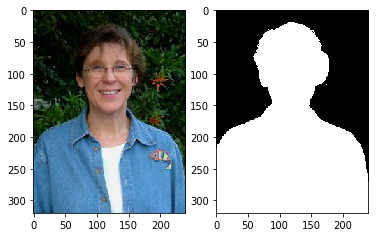

In [11]:
_ = PairHorizontalFlipRandomized(0.5)(*dataset_test.__getitem__(image_idx))
fig, [ax1, ax2] = plt.subplots(1, 2)
ax1.imshow(_[0])
ax2.imshow(_[1])

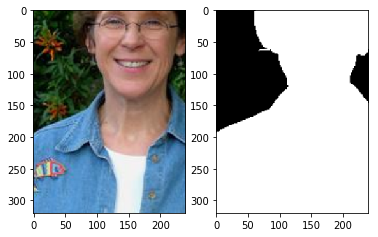

In [12]:
_ = PairRandomResizedCropRandomized(0.5, 0.6)(*dataset_test.__getitem__(image_idx))
fig, [ax1, ax2] = plt.subplots(1, 2)
ax1.imshow(_[0])
ax2.imshow(_[1])

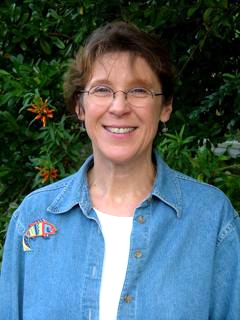

In [13]:
ColorJitterRandomized(1., [0.6, 1.4])(dataset_test.__getitem__(image_idx)[0])

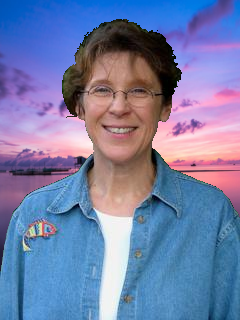

In [14]:
PairBackgroundChangerRandomized(1., backgrounds)(*dataset_test.__getitem__(image_idx))[0]

Добавьте случайные преобразования в ваши датасеты. Также, добавьте преобразование в tensor и нормализацию для изображения:

```
transforms.ToTensor()
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
```

In [15]:
backgrounds = torchvision.datasets.ImageFolder(os.path.join(base_path, './data/backgrounds/'))

pair_transform = PairCompose([
    PairHorizontalFlipRandomized(proba=.5),
    PairRandomResizedCropRandomized(proba=0.5, ratio=0.9),
    PairBackgroundChangerRandomized(proba=0.1, backgrounds=backgrounds),
])

transform_train = torchvision.transforms.Compose([
    ColorJitterRandomized(proba=0.5, brightness=[0.6, 1.4]),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

target_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

dataset_test = PhotosDataset(
    root=os.path.join(base_path, 'data'), download=True, train=False,
    transform=transform_test, target_transform=target_transform
)
dataset_train = PhotosDataset(
    root=os.path.join(base_path, 'data'), download=False, train=True,
    transform=transform_train, target_transform=target_transform, pair_transform=pair_transform
)

Функция для отображения изображения:

In [16]:
def show_idx_image(dataset, idx):
    mask_img = dataset[idx]

    image_to_show = mask_img[0].transpose(0, 1).transpose(1, 2).numpy()
    image_to_show = (image_to_show * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
    image_to_show = np.clip(image_to_show, 0, 1)

    mask_to_show = mask_img[1][0].numpy()

    fig, ax = plt.subplots(1, 3)
    fig.set_figwidth(7)
    fig.set_figheight(3)


    plt.subplot(1, 2, 1)
    plt.imshow(image_to_show)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_to_show)
    plt.axis('off')

Отобразите несколько изображений и масок, на которых будет видна правильная работа вашего модуля аугментации данных.

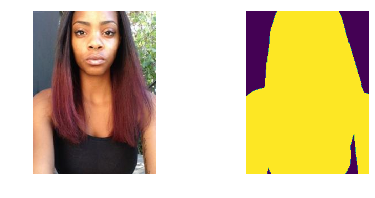

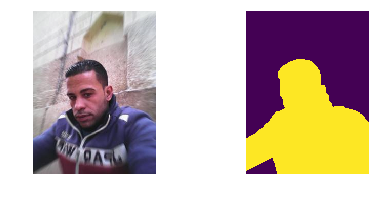

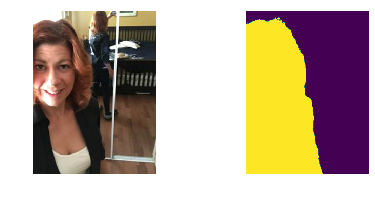

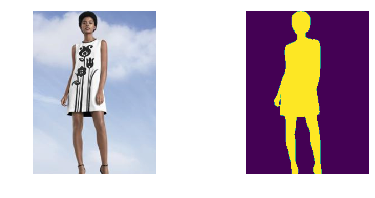

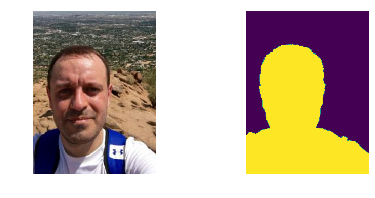

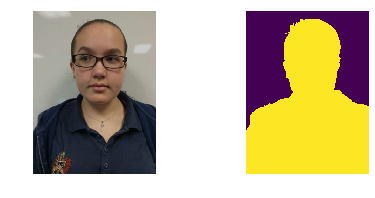

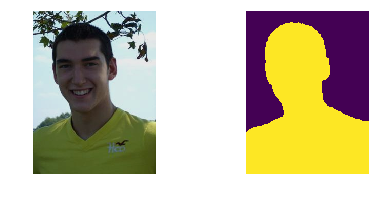

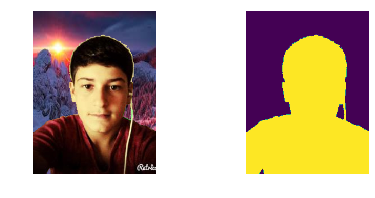

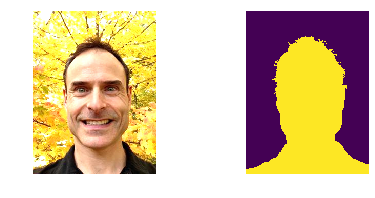

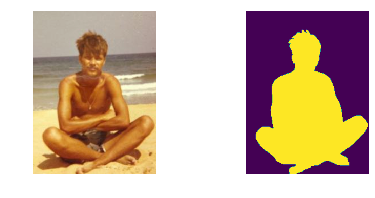

In [17]:
for _ in range(10):
    show_idx_image(dataset_train, np.random.randint(len(dataset_train)))

## Загрузчики

При обучении сети удобнее работать не с датасетами, а с загрузчиками. Загрузчики создаются на основе датасета и позволяют итерироваться по батчам из него.

Обратите внимание на параметры DataLoader. При num_workers > 1, батчи готовятся (загружаются картинки, обрабатываются и т.д.) сразу в нескольких фоновых процессах. С помощью параметра shuffle можно подавать картинки на обучение в случайном порядке.

In [18]:
dataloader_train = DataLoader(dataset_train, batch_size=16, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=16)

## DiceLoss (1 балл)

Функция потерь реализовывается как и все стандартные нейронные модули в pytorch, через nn.Module. В ячейке ниже вам предлагается реализовать фукцию потерь dice (аналог меры Джаккарда).

Результат dice loss определим как:

$$
1 - \frac{2\sum_{i, j}a_{ij}b_{ij}}{\sum_{ij}(a_{ij} + b_{ij} + \varepsilon)}
$$

где $a_{ij} \in [0, 1]$ — предсказанная вероятность нахождения человека в пикселе изображения, $b_{ij}$ — разметка для пикселя изображения.

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else None
dtype = torch.float64

In [20]:
class DiceLoss(nn.Module):
    def __init__(self, eps=1e-7, reduction='none', with_logits=True):
        """
        Arguments
        ---------
        eps : float
            eps in denominator
        reduction : string ('none', 'mean' or 'sum')
            specifies the reduction to apply to the output:
            
            'none': no reduction will be applied
            'mean': the sum of the output will be divided by the number of batches in the output
            'sum':  the output will be summed. 
        with_logits : bool
            If True, use additional sigmoid for inputs
        """
        super().__init__()
        self.eps = torch.tensor(eps, dtype=dtype, device=device)
        self.reduction = reduction
        self.with_logits = with_logits
        
    def forward(self, logits, true_labels):
        batch_size = logits.shape[0]
        true_labels = true_labels.to(device=device, dtype=dtype)
        if self.with_logits:
            logits = torch.sigmoid(logits)
        
        loss_value = (
            torch.tensor(1., dtype=dtype, device=device) 
            - torch.tensor(2.,dtype=dtype, device=device) * torch.sum((logits * true_labels).view(batch_size, -1), dim=1)
            / torch.sum((logits + true_labels + self.eps).view(batch_size, -1), dim=1)
        )
        
    
        if self.reduction == 'sum':
            loss_value = torch.sum(loss_value)
        elif self.reduction == 'mean':
            loss_value = torch.mean(loss_value)
            
        return loss_value

In [21]:
class BCEPlusDice(nn.Module):
    def __init__(self, reduction='none', alpha=0.5):
        super().__init__()
        self.reduction = reduction
        self.alpha = alpha
        self.BCE = torch.nn.BCEWithLogitsLoss(reduction=reduction)
        self.Dice = DiceLoss(reduction=reduction)
        
    def forward(self, logits, true_labels):
        return self.alpha * self.BCE(logits, true_labels) + (1. - self.alpha) * self.Dice(logits, true_labels)

Проверка реализации:

In [22]:
logits = torch.tensor([
    [[0, 0.5], [0.5, 1]],
    [[0.1, 0.1], [0, 0]],
]).to(device=device, dtype=dtype)

target = torch.tensor([
    [[0, 1], [1, 1]],
    [[1, 0], [0, 1]],
]).to(device=device, dtype=dtype)

losses = DiceLoss(with_logits=False, reduction=None, eps=1e-7)(logits, target)
npt.assert_almost_equal(losses.cpu().numpy(), np.array([0.2, 0.90909]), decimal=4)

loss = DiceLoss(with_logits=False, reduction='mean', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.cpu().numpy()), 0.554545, decimal=4)

loss = DiceLoss(with_logits=False, reduction='sum', eps=1e-7)(logits, target)
npt.assert_almost_equal(float(loss.cpu().numpy()), 1.10909, decimal=4)

## Unet (2 балла)

Для решения задачи сегментации будем использовать UNet с энкодером из первых блоков предобученного VGG13. Архитектура сети реализована за вас ниже.

### Encoder

In [23]:
from torchvision.models.vgg import vgg13

In [24]:
class VGG13Encoder(torch.nn.Module):
    def __init__(self, num_blocks, pretrained=True):
        super().__init__()
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList()
        feature_extractor = vgg13(pretrained=pretrained).features
        for i in range(self.num_blocks):
            self.blocks.append(
                torch.nn.Sequential(*[feature_extractor[j]
                                      for j in range(i * 5, i * 5 + 4)]))

    def forward(self, x):
        activations = []
        for i in range(self.num_blocks):
            x = self.blocks[i](x)
            activations.append(x)
            if i != self.num_blocks - 1:
                x = torch.functional.F.max_pool2d(x, kernel_size=2, stride=2)
        return activations

### Decoder

In [25]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )

    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.conv1(torch.cat([left, x], 1))
        x = self.conv2(x)
        return x

In [26]:
class Decoder(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlock(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

### Unet Class

In [27]:
class UNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = Decoder(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

### Eval Functions

In [28]:
def evaluate_net(net, testloader, criterion, val_criterion, device, dtype):
    net = net.eval()

    loss = 0.
    correct = 0.
    total = 0.
    
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device=device, dtype=dtype)
            labels = labels.to(device=device, dtype=dtype)

            total += 1
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            correct += val_criterion(outputs, labels).item()
    
    mean_loss = loss / total
    metric = correct / total
    
    return mean_loss, metric

In [29]:
net =  UNet().to(device=device, dtype=dtype)

print(evaluate_net(
    net, dataloader_test, 
    DiceLoss(reduction='mean'), torch.nn.BCEWithLogitsLoss(reduction='mean'), 
    device, dtype
))

(0.4787435387389459, 0.7053952185927376)


Теперь применим сеть на практике!

Обучите сеть на обучающей выборке и протестируйте качество на тестовой выборке.

Сначала при обучении используйте только кросс-энтропию (torch.nn.BCEWithLogitsLoss будет более удобна для бинарного случая). Зафиксируйте результат.

Сравните между собой несколько стратегий оптимизации (только кросс-энтропия, только dice loss, сумма двух лоссов с весами). Сделайте выводы.

### Training Functions

In [30]:
def train_net(
    net_class, optimizer_class, loss_class, 
    criterion_1_class, criterion_2_class, 
    n_iters, lr, weight_decay, verbose
):
    
    net = net_class().to(device=device, dtype=dtype)
    optimizer = optimizer_class(net.parameters(), lr=lr, weight_decay=weight_decay)
    loss = loss_class(reduction='mean')
    criterion_1 = criterion_1_class(reduction='mean')
    criterion_2 = criterion_2_class(reduction='mean')

    losses_crit_1_train = []
    losses_crit_1_test = []
    losses_crit_2_train = []
    losses_crit_2_test = []
    
    dataloader_len = len(dataloader_train)
    
    for n_iter in range(n_iters):
        prev_time = time.time()
        for idx, (images, labels) in enumerate(dataloader_train):
            optimizer.zero_grad()

            images = images.to(device=device, dtype=dtype)
            labels = labels.to(device=device, dtype=dtype)
            loss_value = torch.tensor(0.)
            output = net(images)
            loss_value = loss(output, labels)
            loss_value.backward()

            optimizer.step()
            
            if verbose and idx % 20 == 0:
                print(
                    "Iteration: {0:d}/{1:d}. Iter Time: {2:.3f}. Train loss over batch: {3:.3f}"
                    .format(idx, dataloader_len, time.time() - prev_time, loss_value.cpu().item())
                )
            prev_time = time.time()

        iter_criterion_1_train, iter_criterion_2_train = evaluate_net(
            net, dataloader_train, criterion_1, criterion_2, device, dtype
        )

        iter_criterion_1_test, iter_criterion_2_test = evaluate_net(
            net, dataloader_test, criterion_1, criterion_2, device, dtype
        )

        losses_crit_1_train.append(iter_criterion_1_train)
        losses_crit_1_test.append(iter_criterion_1_test)

        losses_crit_2_train.append(iter_criterion_2_train)
        losses_crit_2_test.append(iter_criterion_2_test)

        if verbose:
            print(
                '\n Iter: {0:d}\nDice Loss (train/test): {1:.4f}/{2:.4f}\nCross Entropy Loss (train/test): {3:.4f}/{4:.4f}'.
                format(
                    n_iter, losses_crit_1_train[-1], losses_crit_1_test[-1], losses_crit_2_train[-1], losses_crit_2_test[-1]
                )
            )
    return net, losses_crit_1_train, losses_crit_1_test, losses_crit_2_train, losses_crit_2_test

In [31]:
def plot_graphs(
    losses_crit_1_train, losses_crit_1_test, losses_crit_2_train, losses_crit_2_test,
    critetion_1_name, critetion_2_name
):
    fig, axes = plt.subplots(1, 2, figsize=(30, 10))
    
    axes[0].set_title(critetion_1_name)
    axes[0].plot(losses_crit_1_train, label='Train')
    axes[0].plot(losses_crit_1_test, label='Test')
    axes[0].legend()
    axes[0].grid()
    axes[0].set_xlabel('Number of iterations')
    
    axes[1].set_title(critetion_2_name)
    axes[1].plot(losses_crit_2_train, label='Train')
    axes[1].plot(losses_crit_2_test, label='Test')
    axes[1].legend()
    axes[1].grid()
    axes[1].set_xlabel('Number of iterations')

In [32]:
def show_net_results(net, dataloader):
    def sigmoid(x):
        sigm = 1. / (1. + np.exp(-x))
        return sigm
    images, labels = next(iter(dataloader))
    result = net(images.to(device=device, dtype=dtype)).cpu().detach()
    fig, axes = plt.subplots(2, 4, figsize=(40, 20))
    axes[0][0].imshow(images[0].numpy().transpose(1, 2, 0))
    axes[0][1].imshow(labels[0][0].numpy())
    axes[0][2].imshow(result[0][0].numpy())
    axes[0][3].imshow(sigmoid(result[0][0].numpy()))
    
    axes[1][0].imshow(images[1].numpy().transpose(1, 2, 0))
    axes[1][1].imshow(labels[1][0].numpy())
    axes[1][2].imshow(result[1][0].numpy())
    axes[1][3].imshow(sigmoid(result[1][0].numpy()))

### Cross Entropy

In [33]:
(
    net_UNet_BCE, losses_crit_1_train, losses_crit_1_test, losses_crit_2_train, losses_crit_2_test
) = train_net(
    UNet, torch.optim.Adam, torch.nn.BCEWithLogitsLoss, 
    DiceLoss, torch.nn.BCEWithLogitsLoss, 
    5, 1e-4, 1e-5, True
)

Iteration: 0/85. Iter Time: 0.125. Train loss over batch: 0.694
Iteration: 20/85. Iter Time: 5.579. Train loss over batch: 0.342
Iteration: 40/85. Iter Time: 5.600. Train loss over batch: 0.181
Iteration: 60/85. Iter Time: 5.606. Train loss over batch: 0.242
Iteration: 80/85. Iter Time: 5.605. Train loss over batch: 0.222

 Iter: 0
Dice Loss (train/test): 0.1115/0.3029
Cross Entropy Loss (train/test): 0.1993/0.5552
Iteration: 0/85. Iter Time: 0.097. Train loss over batch: 0.184
Iteration: 20/85. Iter Time: 5.611. Train loss over batch: 0.226
Iteration: 40/85. Iter Time: 5.602. Train loss over batch: 0.221
Iteration: 60/85. Iter Time: 5.602. Train loss over batch: 0.198
Iteration: 80/85. Iter Time: 5.602. Train loss over batch: 0.137

 Iter: 1
Dice Loss (train/test): 0.0871/0.2531
Cross Entropy Loss (train/test): 0.1590/0.4908
Iteration: 0/85. Iter Time: 0.155. Train loss over batch: 0.170
Iteration: 20/85. Iter Time: 5.599. Train loss over batch: 0.189
Iteration: 40/85. Iter Time: 5.60

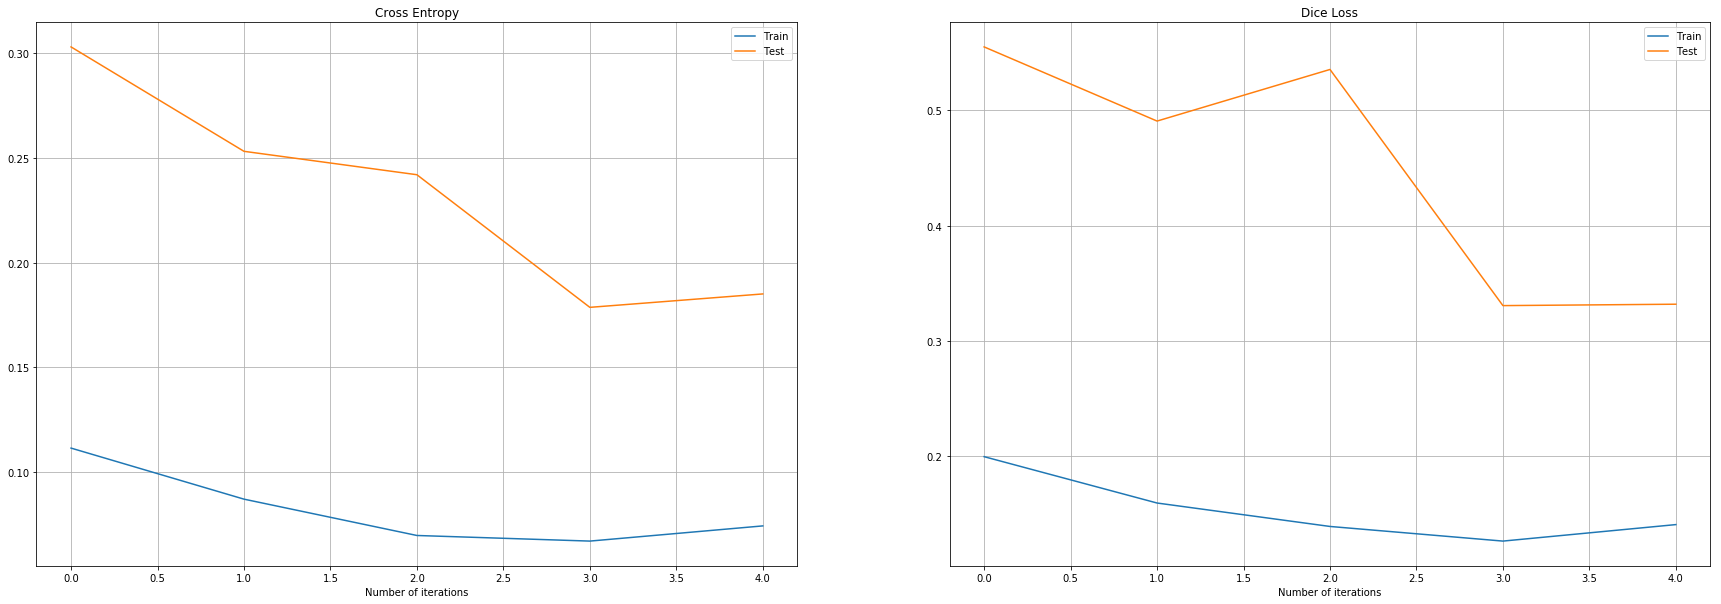

In [34]:
plot_graphs(
    losses_crit_1_train, losses_crit_1_test, losses_crit_2_train, losses_crit_2_test,
    'Cross Entropy', 'Dice Loss'
)

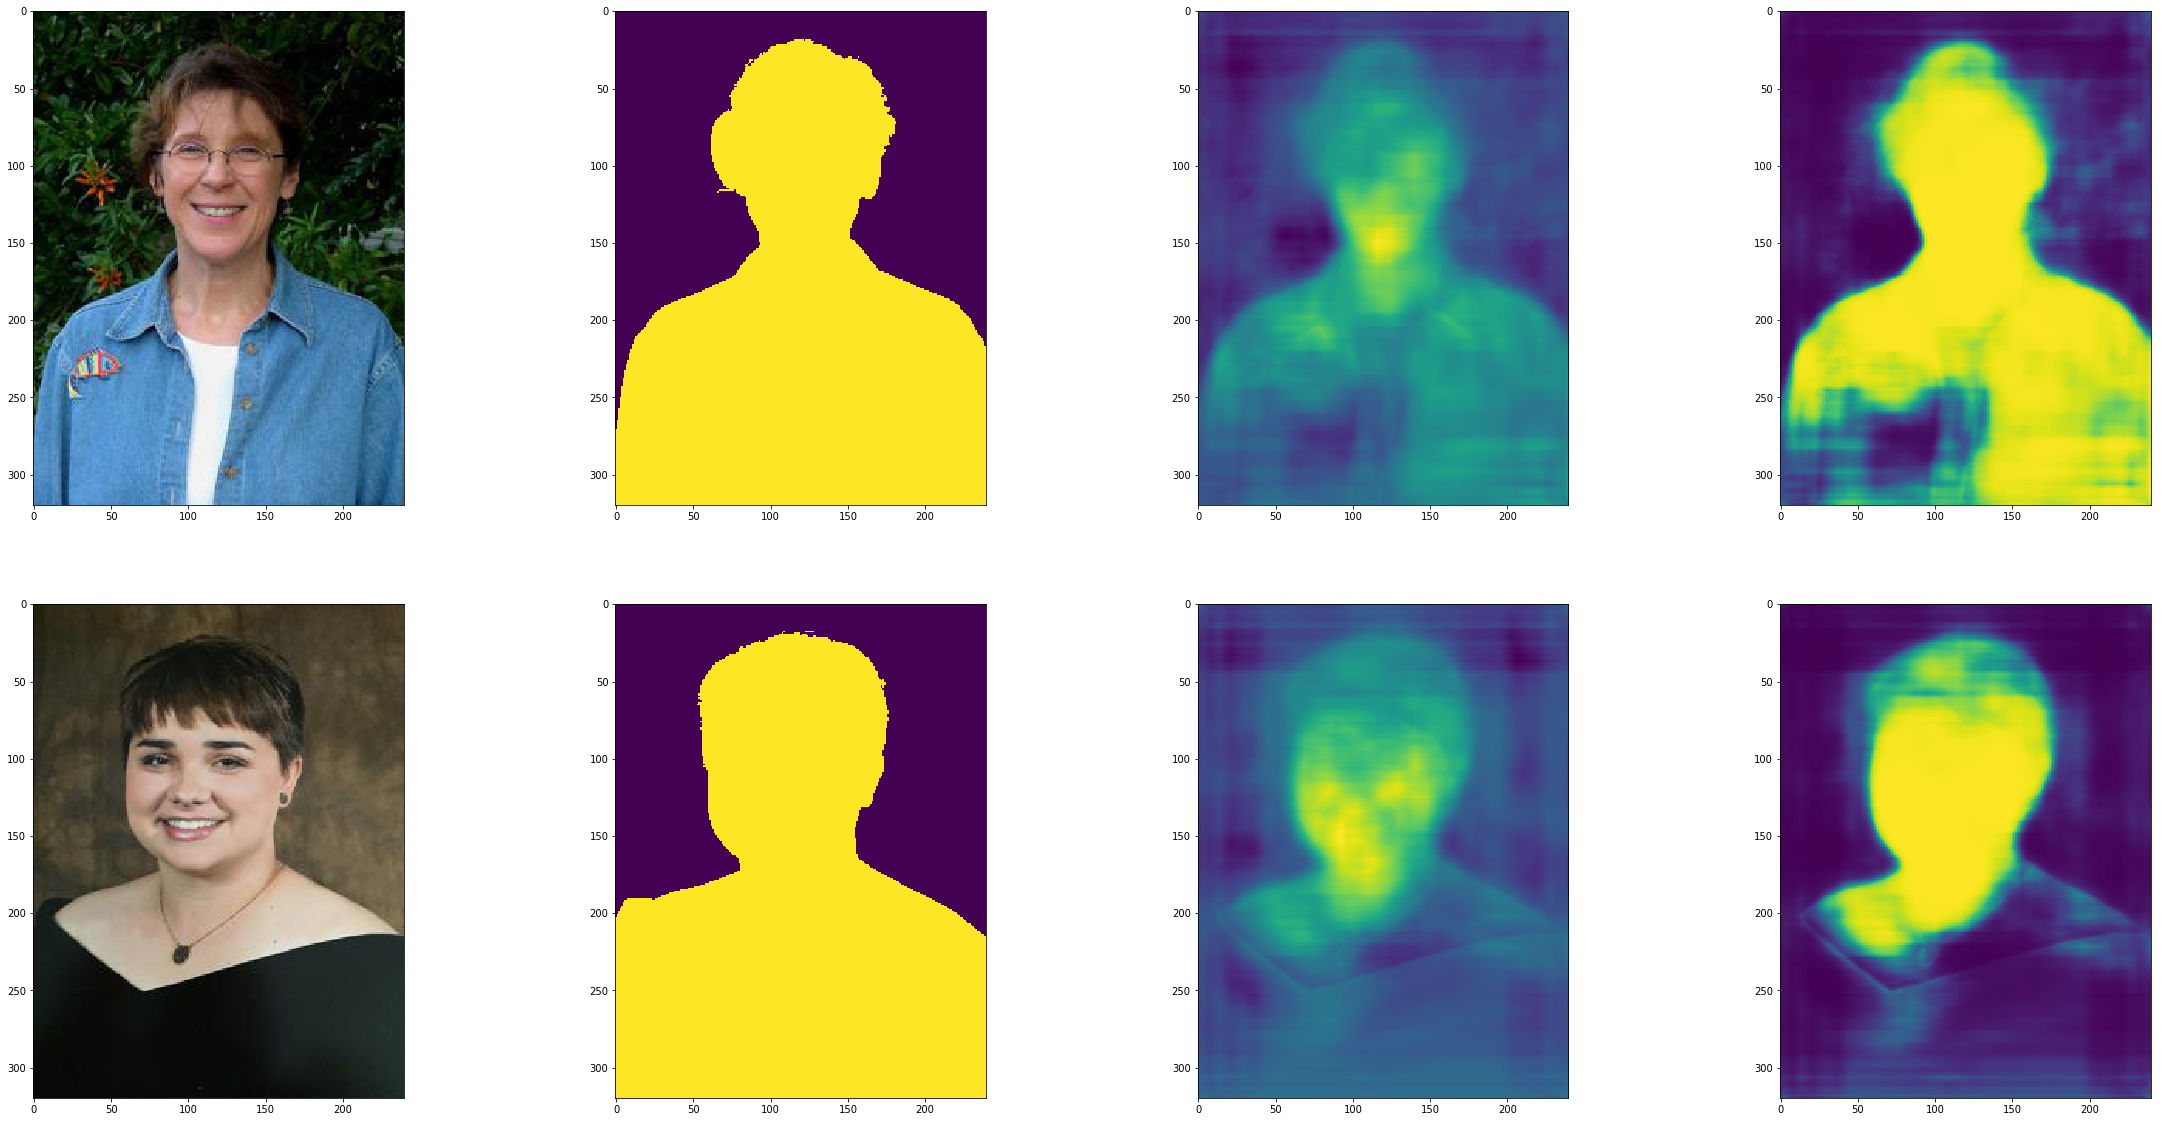

In [35]:
show_net_results(net_UNet_BCE, dataloader_test)

### Dice Loss

In [36]:
(
    net_UNet_Dice, losses_crit_1_train, losses_crit_1_test, losses_crit_2_train, losses_crit_2_test
) = train_net(
    UNet, torch.optim.Adam, DiceLoss, 
    DiceLoss, torch.nn.BCEWithLogitsLoss, 
    5, 1e-4, 1e-5, True
)

Iteration: 0/85. Iter Time: 4.258. Train loss over batch: 0.502
Iteration: 20/85. Iter Time: 5.551. Train loss over batch: 0.212
Iteration: 40/85. Iter Time: 5.588. Train loss over batch: 0.134
Iteration: 60/85. Iter Time: 5.575. Train loss over batch: 0.112
Iteration: 80/85. Iter Time: 5.589. Train loss over batch: 0.092

 Iter: 0
Dice Loss (train/test): 0.0871/0.2316
Cross Entropy Loss (train/test): 31.2878/43.9916
Iteration: 0/85. Iter Time: 4.230. Train loss over batch: 0.119
Iteration: 20/85. Iter Time: 5.586. Train loss over batch: 0.082
Iteration: 40/85. Iter Time: 5.594. Train loss over batch: 0.068
Iteration: 60/85. Iter Time: 5.586. Train loss over batch: 0.068
Iteration: 80/85. Iter Time: 5.588. Train loss over batch: 0.084

 Iter: 1
Dice Loss (train/test): 0.0747/0.3149
Cross Entropy Loss (train/test): 9.8480/31.5268
Iteration: 0/85. Iter Time: 4.298. Train loss over batch: 0.047
Iteration: 20/85. Iter Time: 5.584. Train loss over batch: 0.062
Iteration: 40/85. Iter Time: 5

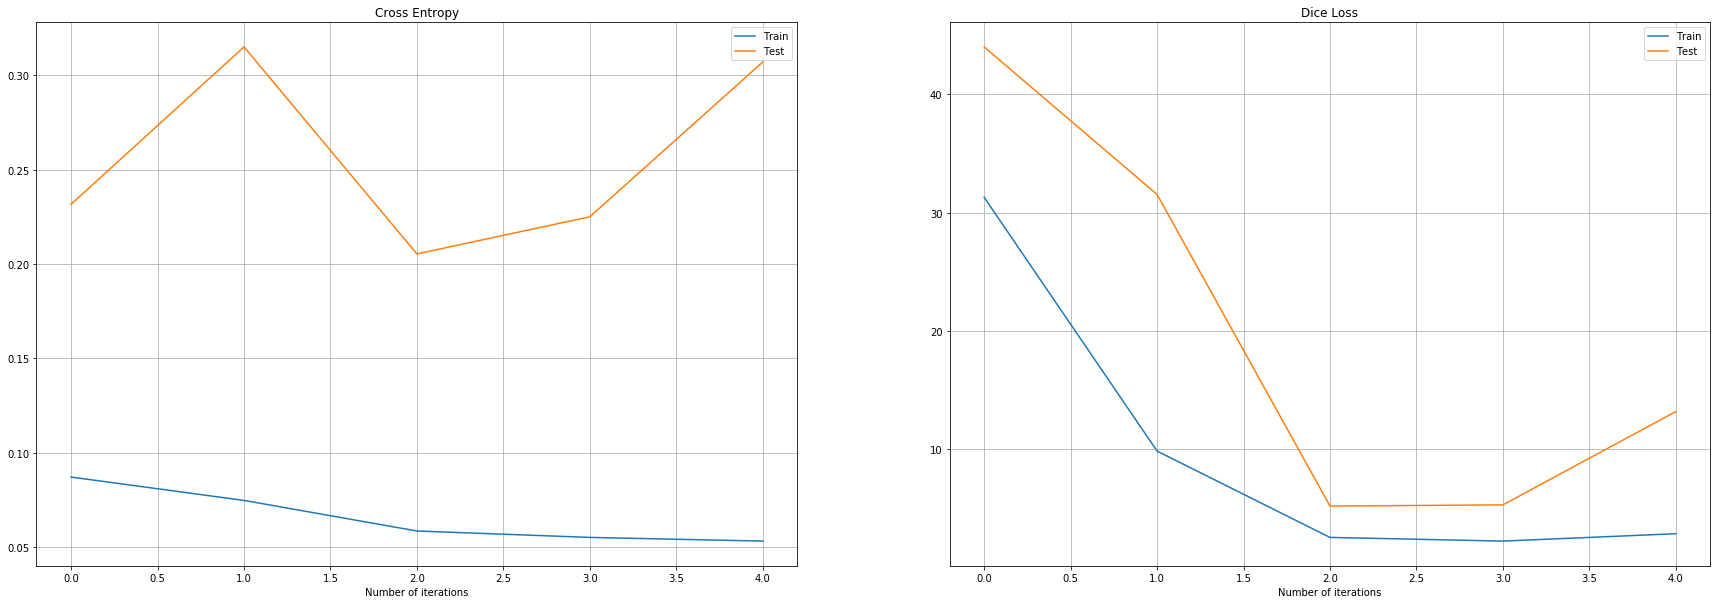

In [37]:
plot_graphs(
    losses_crit_1_train, losses_crit_1_test, losses_crit_2_train, losses_crit_2_test,
    'Cross Entropy', 'Dice Loss'
)

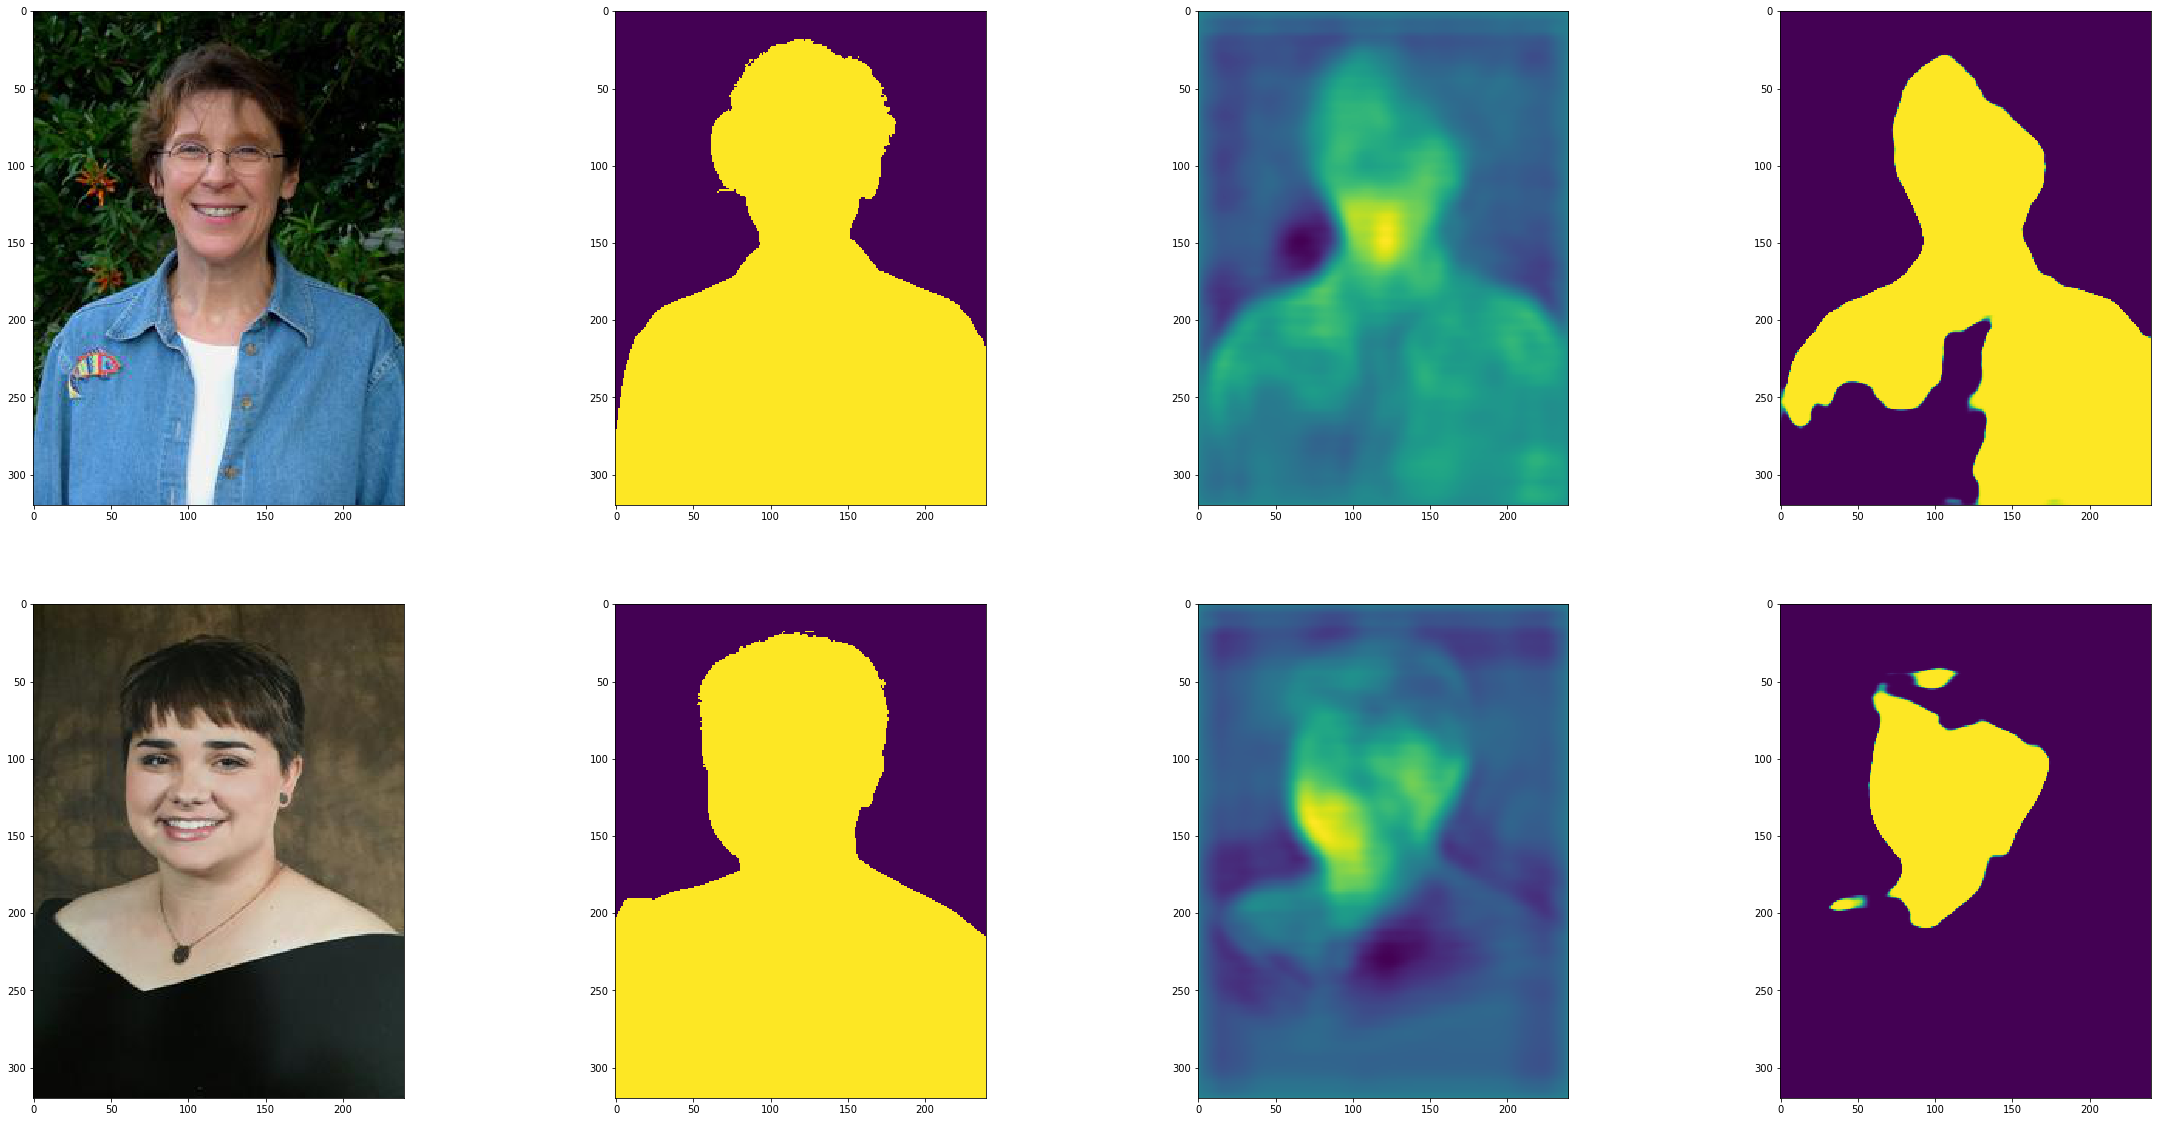

In [38]:
show_net_results(net_UNet_Dice, dataloader_test)

### Cross Entropy + Dice Loss

In [39]:
(
    net_UNet_BCEDice, losses_crit_1_train, losses_crit_1_test, losses_crit_2_train, losses_crit_2_test
) = train_net(
    UNet, torch.optim.Adam, BCEPlusDice, 
    DiceLoss, torch.nn.BCEWithLogitsLoss, 
    5, 1e-4, 1e-5, True
)

Iteration: 0/85. Iter Time: 4.463. Train loss over batch: 0.582
Iteration: 20/85. Iter Time: 5.583. Train loss over batch: 0.236
Iteration: 40/85. Iter Time: 5.600. Train loss over batch: 0.150
Iteration: 60/85. Iter Time: 5.595. Train loss over batch: 0.197
Iteration: 80/85. Iter Time: 5.598. Train loss over batch: 0.204

 Iter: 0
Dice Loss (train/test): 0.1031/0.2880
Cross Entropy Loss (train/test): 0.1924/0.5598
Iteration: 0/85. Iter Time: 4.171. Train loss over batch: 0.155
Iteration: 20/85. Iter Time: 5.608. Train loss over batch: 0.176
Iteration: 40/85. Iter Time: 5.600. Train loss over batch: 0.151
Iteration: 60/85. Iter Time: 5.591. Train loss over batch: 0.149
Iteration: 80/85. Iter Time: 5.600. Train loss over batch: 0.142

 Iter: 1
Dice Loss (train/test): 0.0872/0.1871
Cross Entropy Loss (train/test): 0.1918/0.3360
Iteration: 0/85. Iter Time: 4.285. Train loss over batch: 0.136
Iteration: 20/85. Iter Time: 5.603. Train loss over batch: 0.126
Iteration: 40/85. Iter Time: 5.60

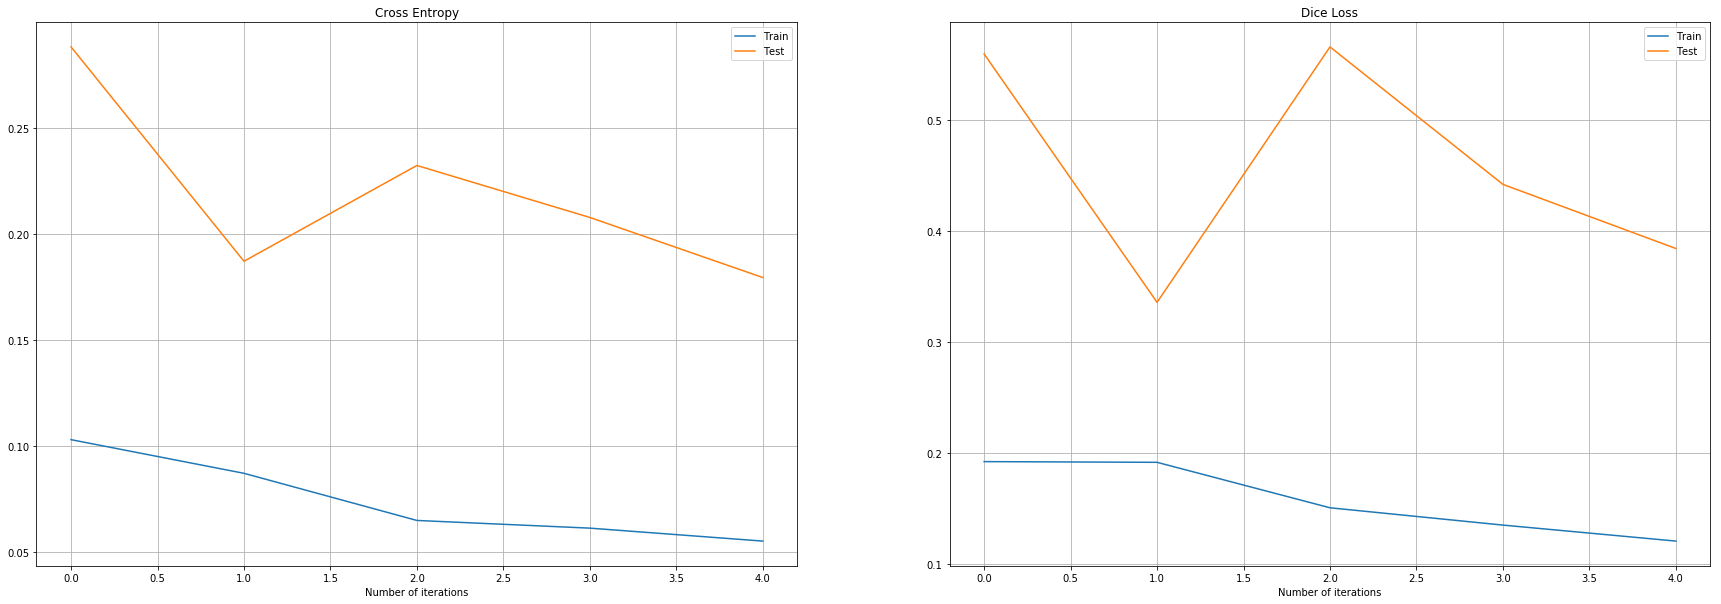

In [40]:
plot_graphs(
    losses_crit_1_train, losses_crit_1_test, losses_crit_2_train, losses_crit_2_test,
    'Cross Entropy', 'Dice Loss'
)

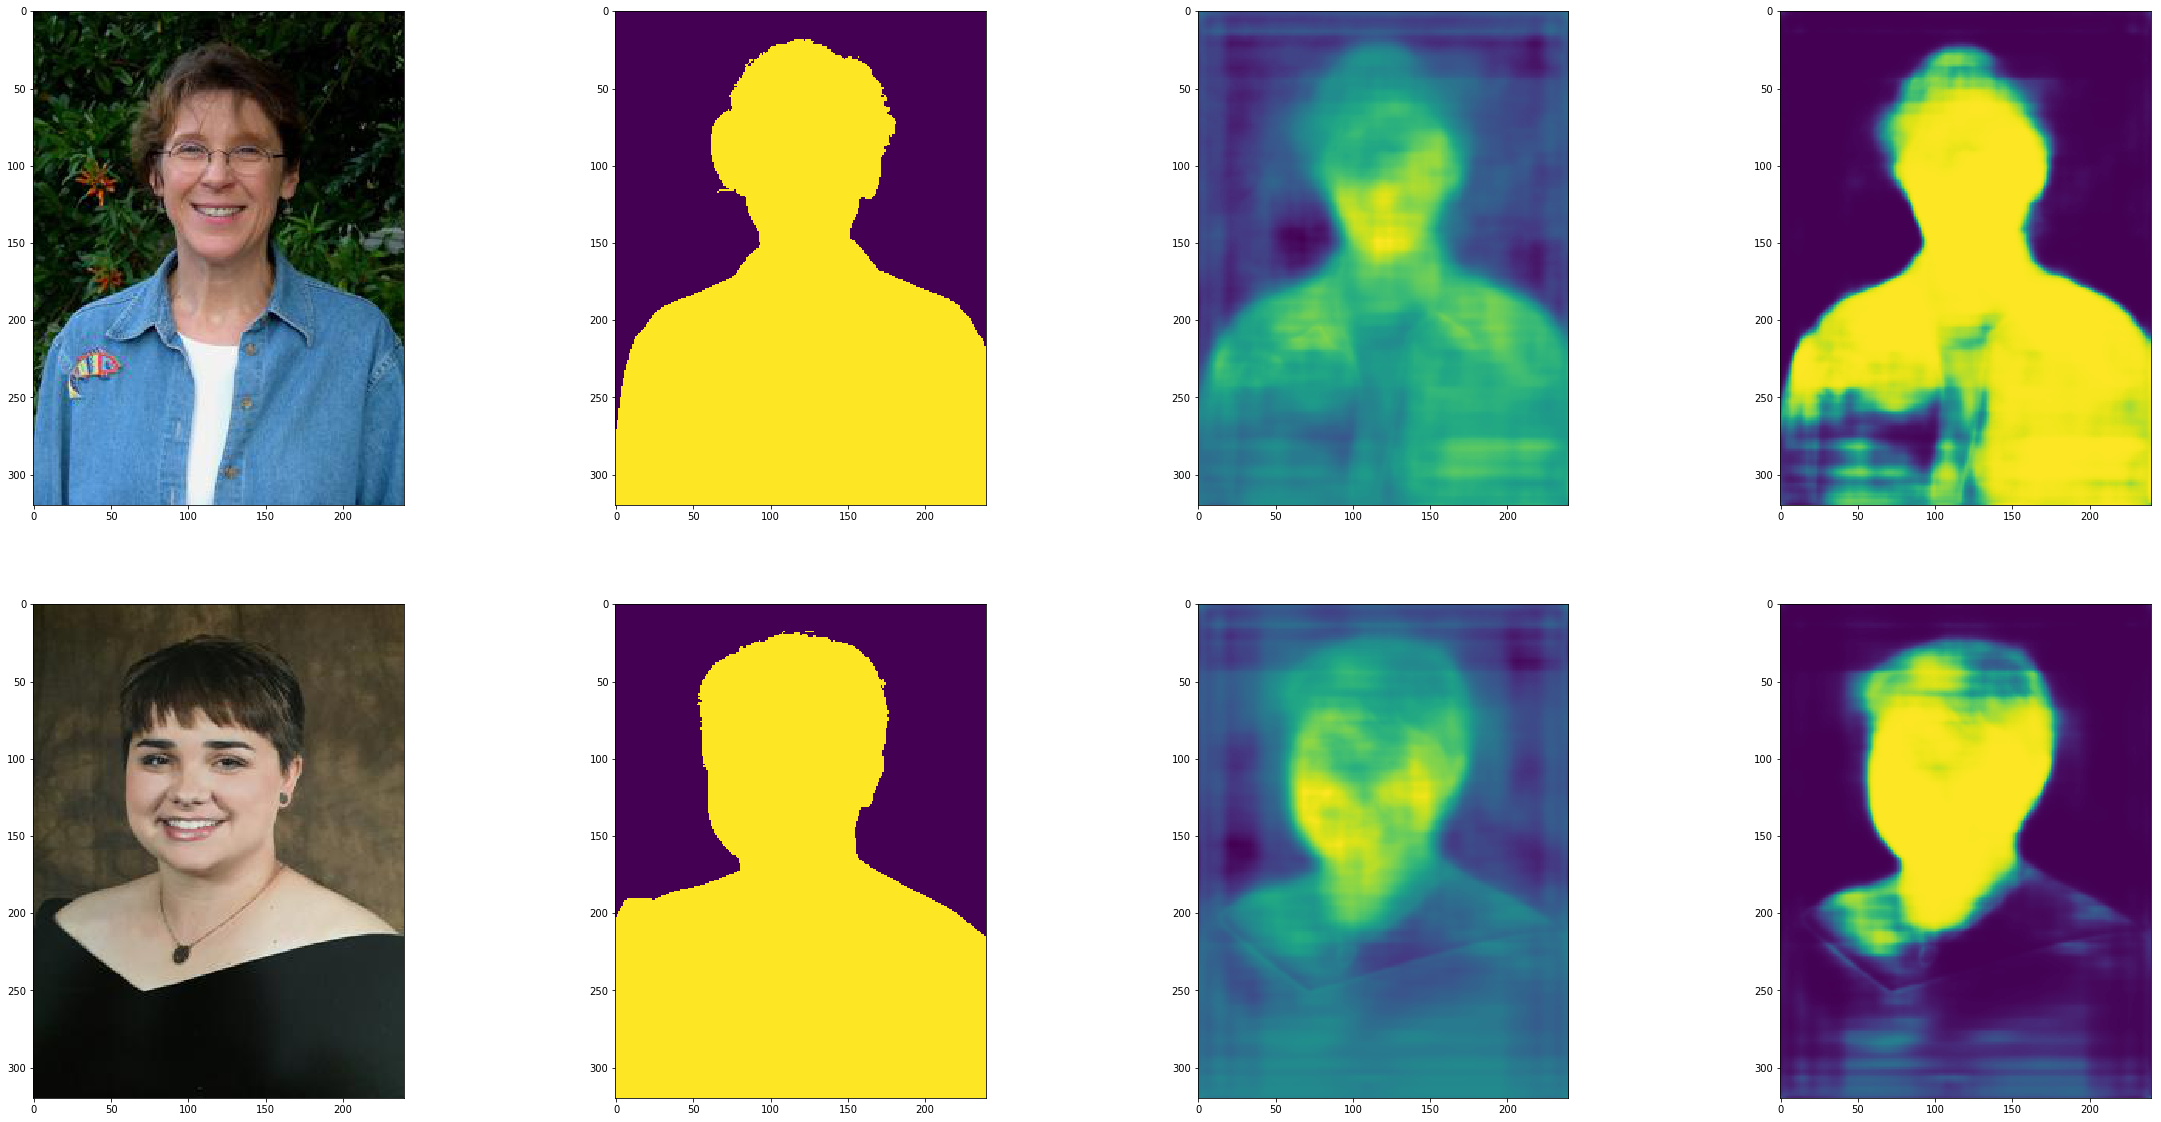

In [41]:
show_net_results(net_UNet_BCEDice, dataloader_test)

## LinkNet (3 балла)

Реализуйте архитектуру LinkNet с использованием энкодера, основанного на VGG13. Архитектура похожа на Unet, но вместо конкатенации слоёв используются skip-connections. Для реализации достаточно переписать структуру декодировщика из предыдущего пункта.

https://arxiv.org/pdf/1707.03718.pdf

### LinkNet Decoder

In [42]:
class DecoderBlockLinkNet(torch.nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.upconv = torch.nn.Conv2d(
            in_channels=out_channels * 2, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv1 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )
        self.conv2 = torch.nn.Conv2d(
            in_channels=out_channels, out_channels=out_channels,
            kernel_size=3, padding=1, dilation=1
        )

    def forward(self, down, left):
        x = torch.nn.functional.interpolate(down, scale_factor=2)
        x = self.upconv(x)
        x = self.conv1(left + x)
        x = self.conv2(x)
        return x

In [43]:
class DecoderLinkNet(nn.Module):
    def __init__(self, num_filters, num_blocks):
        super().__init__()

        for i in range(num_blocks):
            self.add_module(f'block{num_blocks - i}', DecoderBlockLinkNet(num_filters * 2**i))

    def forward(self, acts):
        up = acts[-1]
        for i, left in enumerate(acts[-2::-1]):
            up = self.__getattr__(f'block{i + 1}')(up, left)
        return up

### LinkNet Class

In [44]:
class LinkNet(torch.nn.Module):
    def __init__(self, num_classes=1, num_filters=64, num_blocks=4):
        super().__init__()
        self.encoder = VGG13Encoder(num_blocks=num_blocks)
        self.decoder = DecoderLinkNet(num_filters=64, num_blocks=num_blocks - 1)
        self.final = torch.nn.Conv2d(
            in_channels=num_filters, out_channels=num_classes, kernel_size=1
        )

    def forward(self, x):
        acts = self.encoder(x)
        x = self.decoder(acts)
        x = self.final(x)
        return x

### Cross Entropy

In [45]:
(
    net_LinkNet_BCE, losses_crit_1_train, losses_crit_1_test, losses_crit_2_train, losses_crit_2_test
) = train_net(
    LinkNet, torch.optim.Adam, torch.nn.BCEWithLogitsLoss, 
    DiceLoss, torch.nn.BCEWithLogitsLoss, 
    5, 1e-4, 1e-5, True
)

Iteration: 0/85. Iter Time: 0.588. Train loss over batch: 0.675
Iteration: 20/85. Iter Time: 4.838. Train loss over batch: 0.310
Iteration: 40/85. Iter Time: 4.848. Train loss over batch: 0.190
Iteration: 60/85. Iter Time: 4.854. Train loss over batch: 0.192
Iteration: 80/85. Iter Time: 4.859. Train loss over batch: 0.302

 Iter: 0
Dice Loss (train/test): 0.1320/0.3669
Cross Entropy Loss (train/test): 0.2086/0.6085
Iteration: 0/85. Iter Time: 0.108. Train loss over batch: 0.223
Iteration: 20/85. Iter Time: 4.854. Train loss over batch: 0.239
Iteration: 40/85. Iter Time: 4.853. Train loss over batch: 0.163
Iteration: 60/85. Iter Time: 4.853. Train loss over batch: 0.193
Iteration: 80/85. Iter Time: 4.858. Train loss over batch: 0.168

 Iter: 1
Dice Loss (train/test): 0.0889/0.3155
Cross Entropy Loss (train/test): 0.1638/0.6573
Iteration: 0/85. Iter Time: 0.108. Train loss over batch: 0.134
Iteration: 20/85. Iter Time: 4.856. Train loss over batch: 0.103
Iteration: 40/85. Iter Time: 4.85

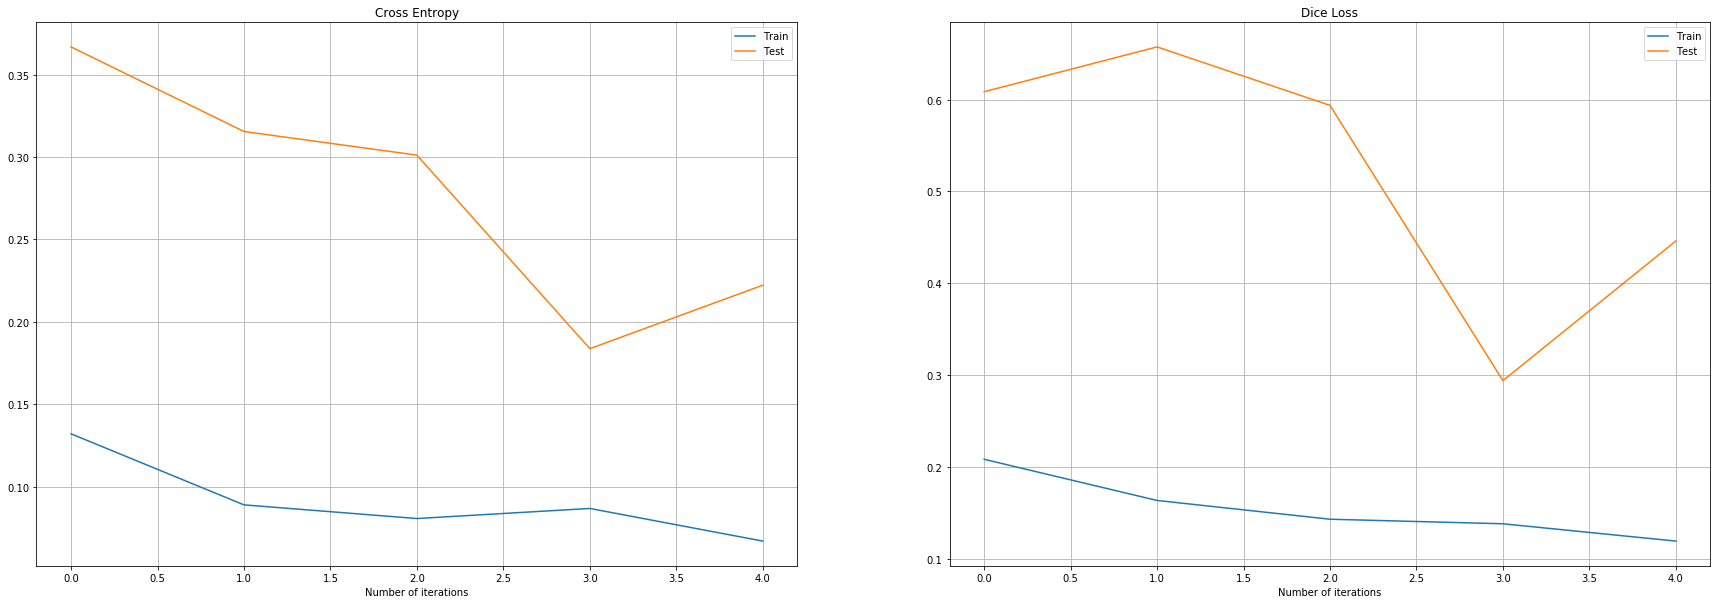

In [46]:
plot_graphs(
    losses_crit_1_train, losses_crit_1_test, losses_crit_2_train, losses_crit_2_test,
    'Cross Entropy', 'Dice Loss'
)

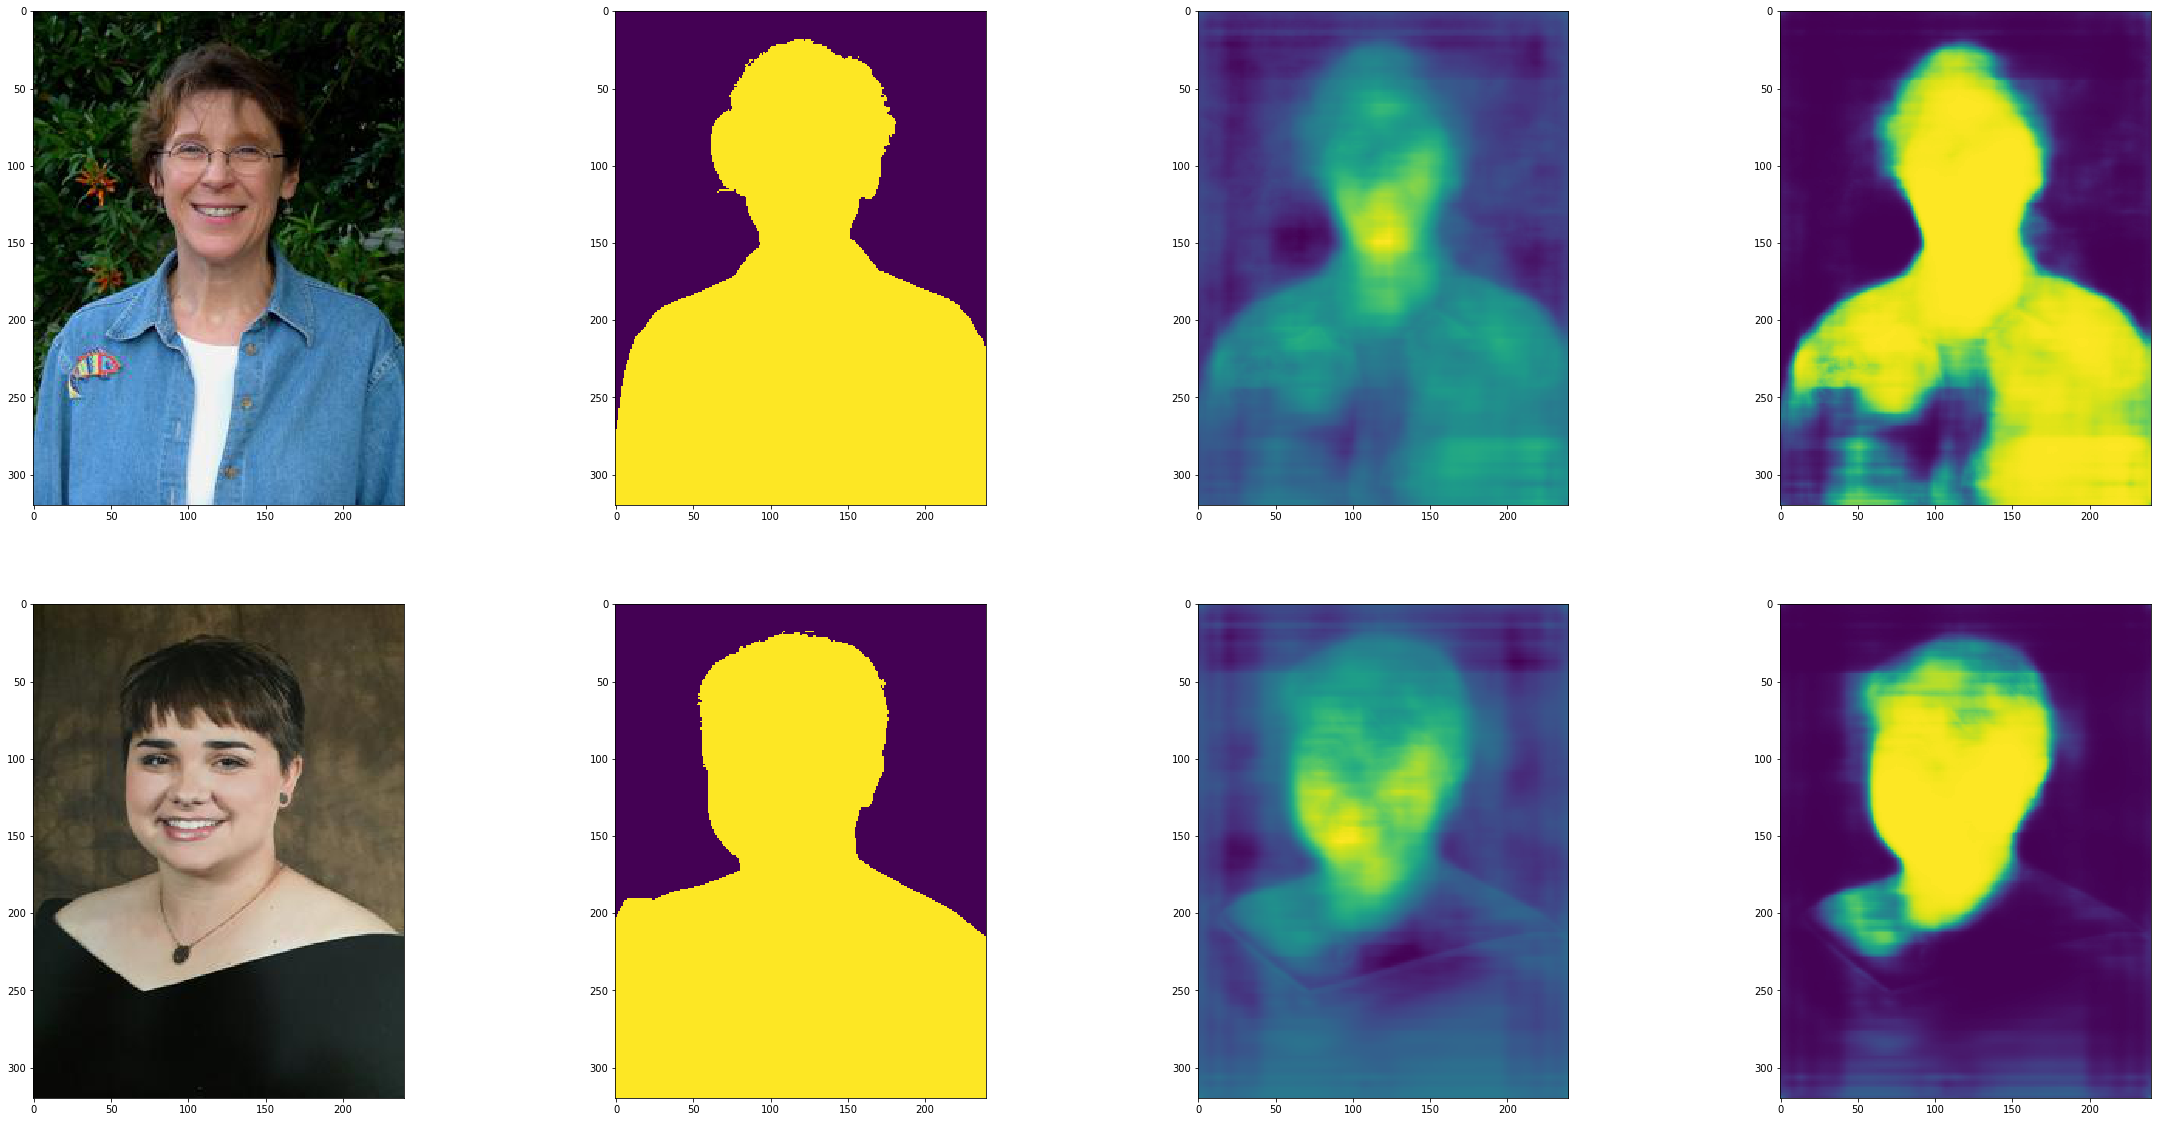

In [47]:
show_net_results(net_LinkNet_BCE, dataloader_test)

### Dice Loss

In [48]:
(
    net_LinkNet_Dice, losses_crit_1_train, losses_crit_1_test, losses_crit_2_train, losses_crit_2_test
) = train_net(
    LinkNet, torch.optim.Adam, DiceLoss, 
    DiceLoss, torch.nn.BCEWithLogitsLoss, 
    5, 1e-4, 1e-5, True
)

Iteration: 0/85. Iter Time: 3.697. Train loss over batch: 0.488
Iteration: 20/85. Iter Time: 4.835. Train loss over batch: 0.190
Iteration: 40/85. Iter Time: 4.832. Train loss over batch: 0.119
Iteration: 60/85. Iter Time: 4.834. Train loss over batch: 0.080
Iteration: 80/85. Iter Time: 4.842. Train loss over batch: 0.080

 Iter: 0
Dice Loss (train/test): 0.0839/0.1670
Cross Entropy Loss (train/test): 13.7953/13.0591
Iteration: 0/85. Iter Time: 3.711. Train loss over batch: 0.071
Iteration: 20/85. Iter Time: 4.835. Train loss over batch: 0.054
Iteration: 40/85. Iter Time: 4.836. Train loss over batch: 0.100
Iteration: 60/85. Iter Time: 4.838. Train loss over batch: 0.107
Iteration: 80/85. Iter Time: 4.839. Train loss over batch: 0.072

 Iter: 1
Dice Loss (train/test): 0.0675/0.2202
Cross Entropy Loss (train/test): 2.2100/4.6252
Iteration: 0/85. Iter Time: 3.713. Train loss over batch: 0.058
Iteration: 20/85. Iter Time: 4.845. Train loss over batch: 0.076
Iteration: 40/85. Iter Time: 4.

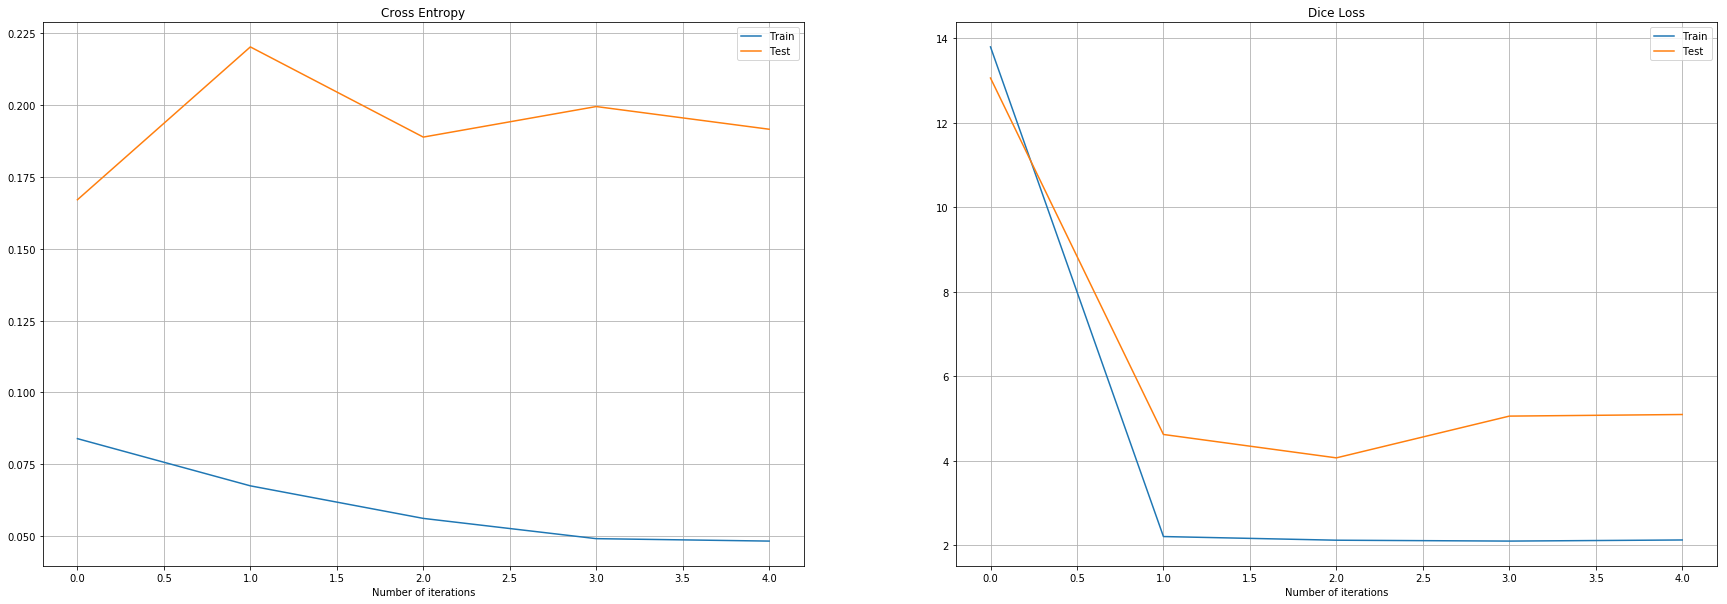

In [49]:
plot_graphs(
    losses_crit_1_train, losses_crit_1_test, losses_crit_2_train, losses_crit_2_test,
    'Cross Entropy', 'Dice Loss'
)

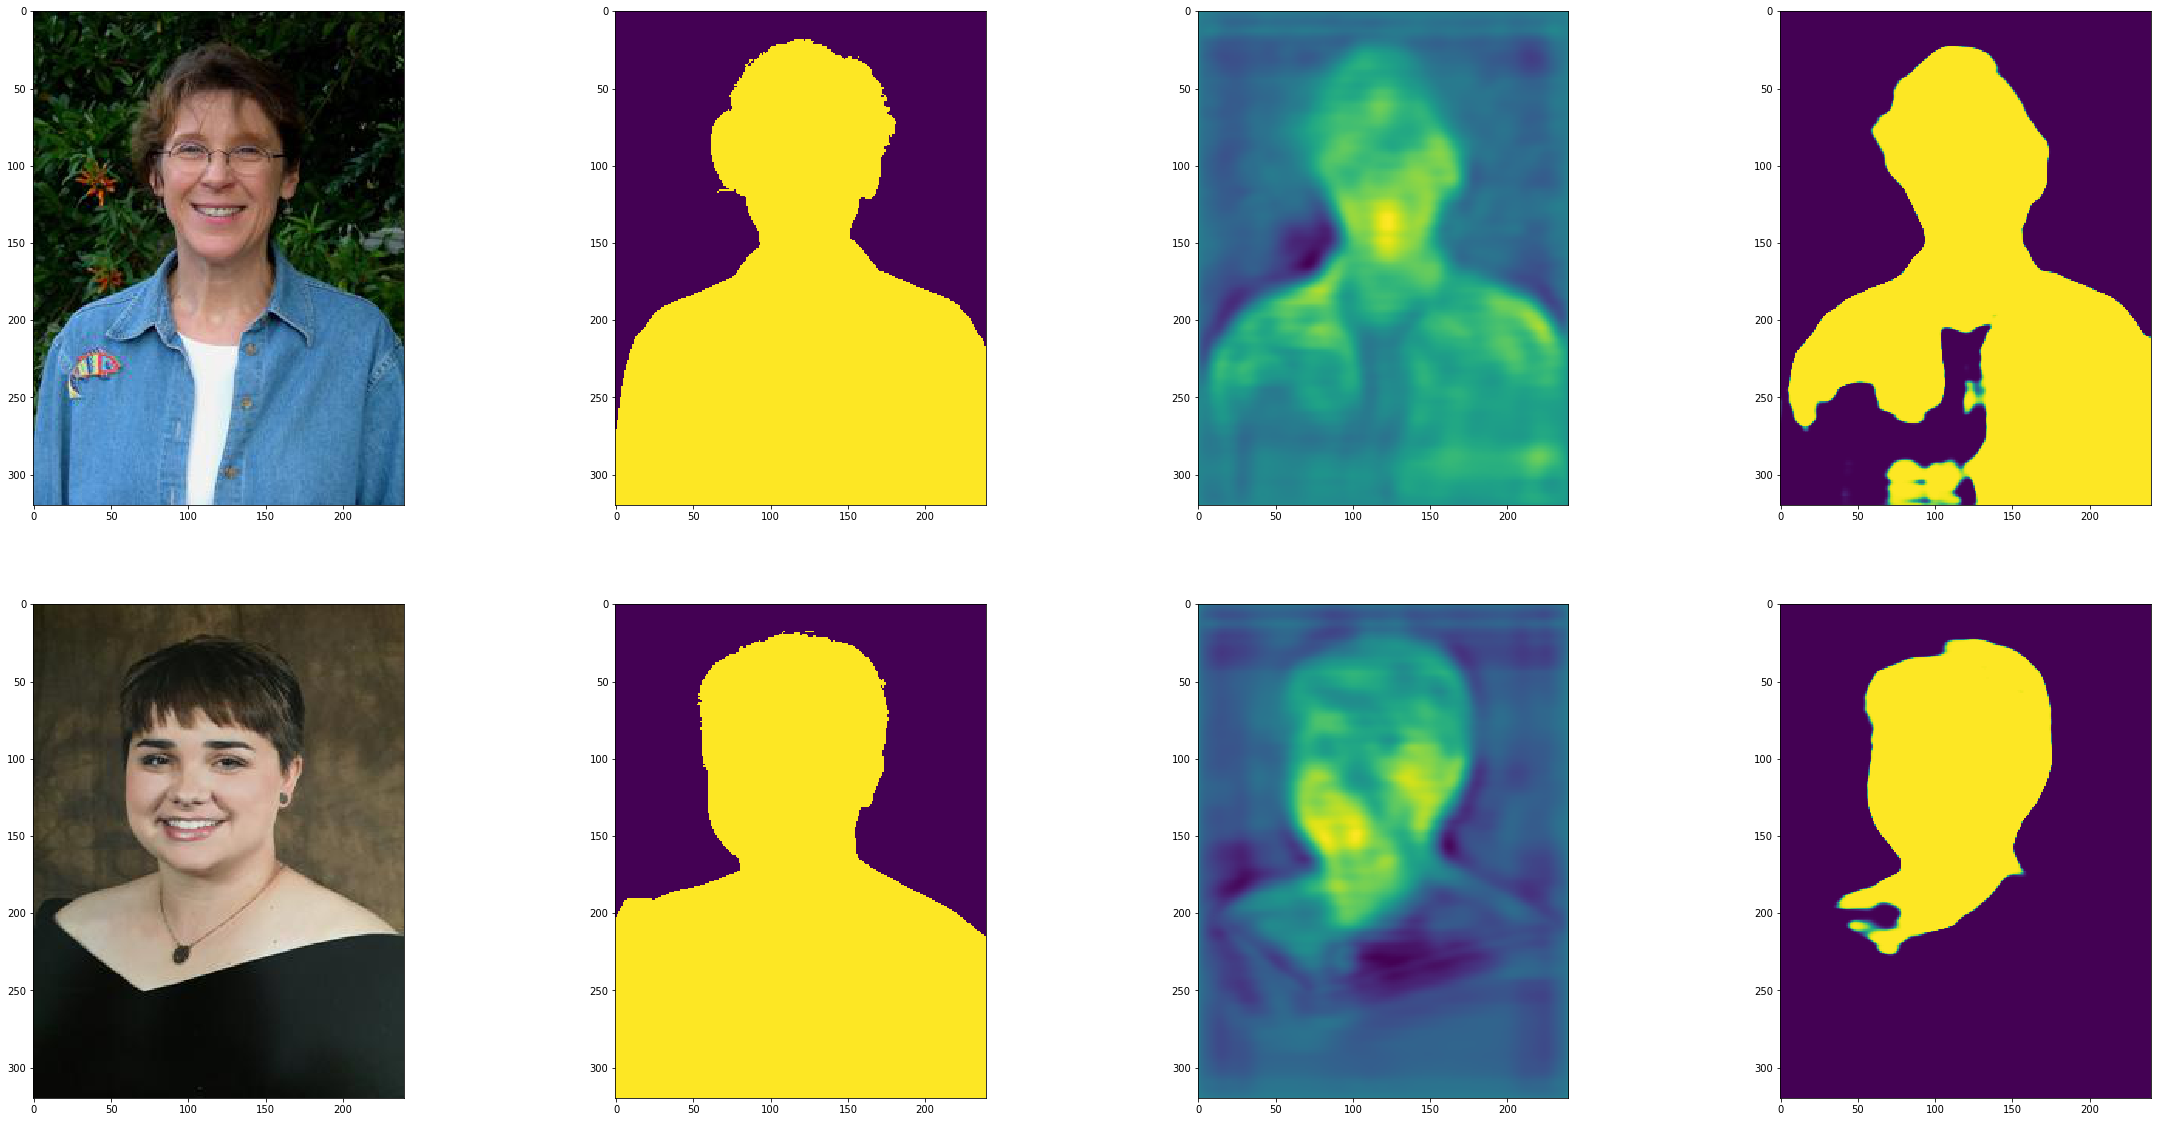

In [50]:
show_net_results(net_LinkNet_Dice, dataloader_test)

### Cross Entropy + Dice Loss

In [51]:
(
    net_LinkNet_BCEDice, losses_crit_1_train, losses_crit_1_test, losses_crit_2_train, losses_crit_2_test
) = train_net(
    LinkNet, torch.optim.Adam, BCEPlusDice, 
    DiceLoss, torch.nn.BCEWithLogitsLoss, 
    5, 1e-4, 1e-5, True
)

Iteration: 0/85. Iter Time: 3.740. Train loss over batch: 0.583
Iteration: 20/85. Iter Time: 4.846. Train loss over batch: 0.282
Iteration: 40/85. Iter Time: 4.855. Train loss over batch: 0.265
Iteration: 60/85. Iter Time: 4.847. Train loss over batch: 0.232
Iteration: 80/85. Iter Time: 4.858. Train loss over batch: 0.138

 Iter: 0
Dice Loss (train/test): 0.1064/0.2439
Cross Entropy Loss (train/test): 0.2191/0.4598
Iteration: 0/85. Iter Time: 3.708. Train loss over batch: 0.223
Iteration: 20/85. Iter Time: 4.857. Train loss over batch: 0.147
Iteration: 40/85. Iter Time: 4.858. Train loss over batch: 0.196
Iteration: 60/85. Iter Time: 4.859. Train loss over batch: 0.167
Iteration: 80/85. Iter Time: 4.853. Train loss over batch: 0.174

 Iter: 1
Dice Loss (train/test): 0.0802/0.2377
Cross Entropy Loss (train/test): 0.1703/0.5224
Iteration: 0/85. Iter Time: 3.710. Train loss over batch: 0.143
Iteration: 20/85. Iter Time: 4.858. Train loss over batch: 0.158
Iteration: 40/85. Iter Time: 4.84

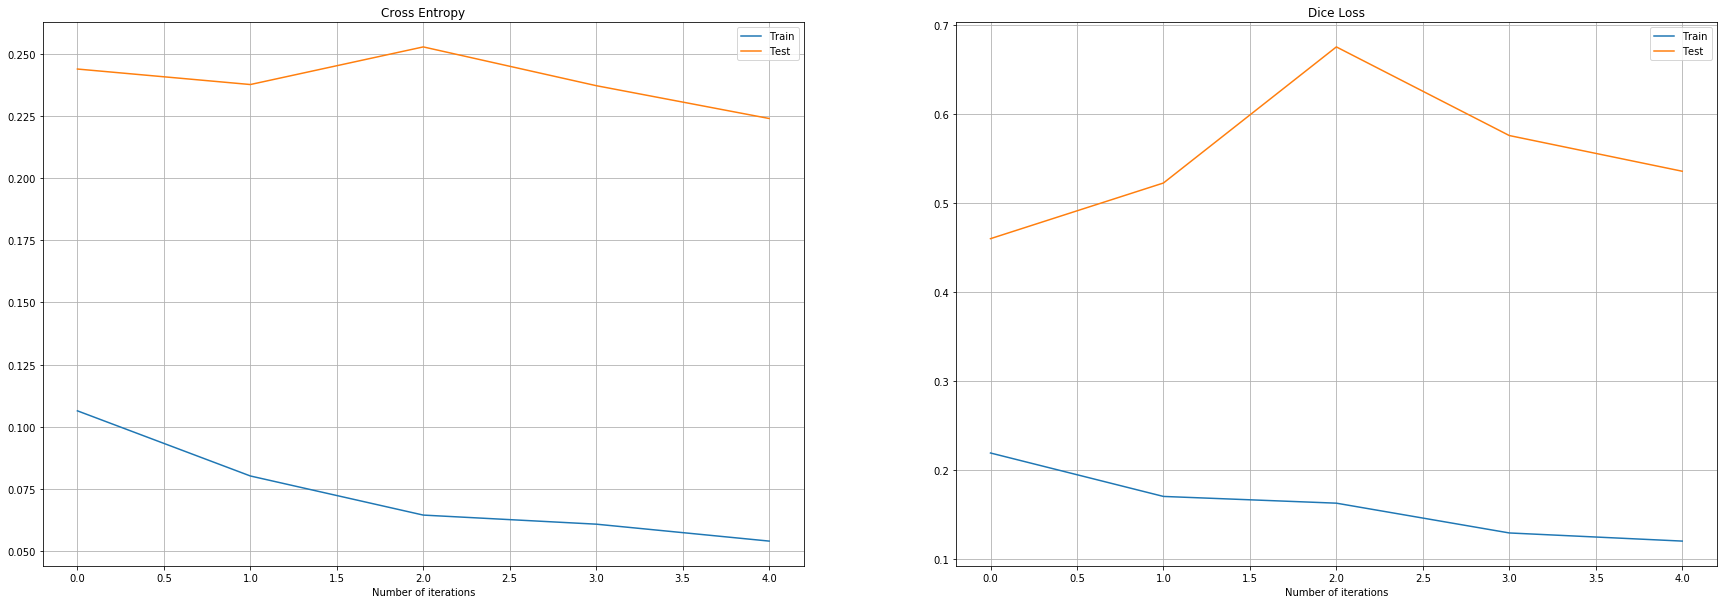

In [52]:
plot_graphs(
    losses_crit_1_train, losses_crit_1_test, losses_crit_2_train, losses_crit_2_test,
    'Cross Entropy', 'Dice Loss'
)

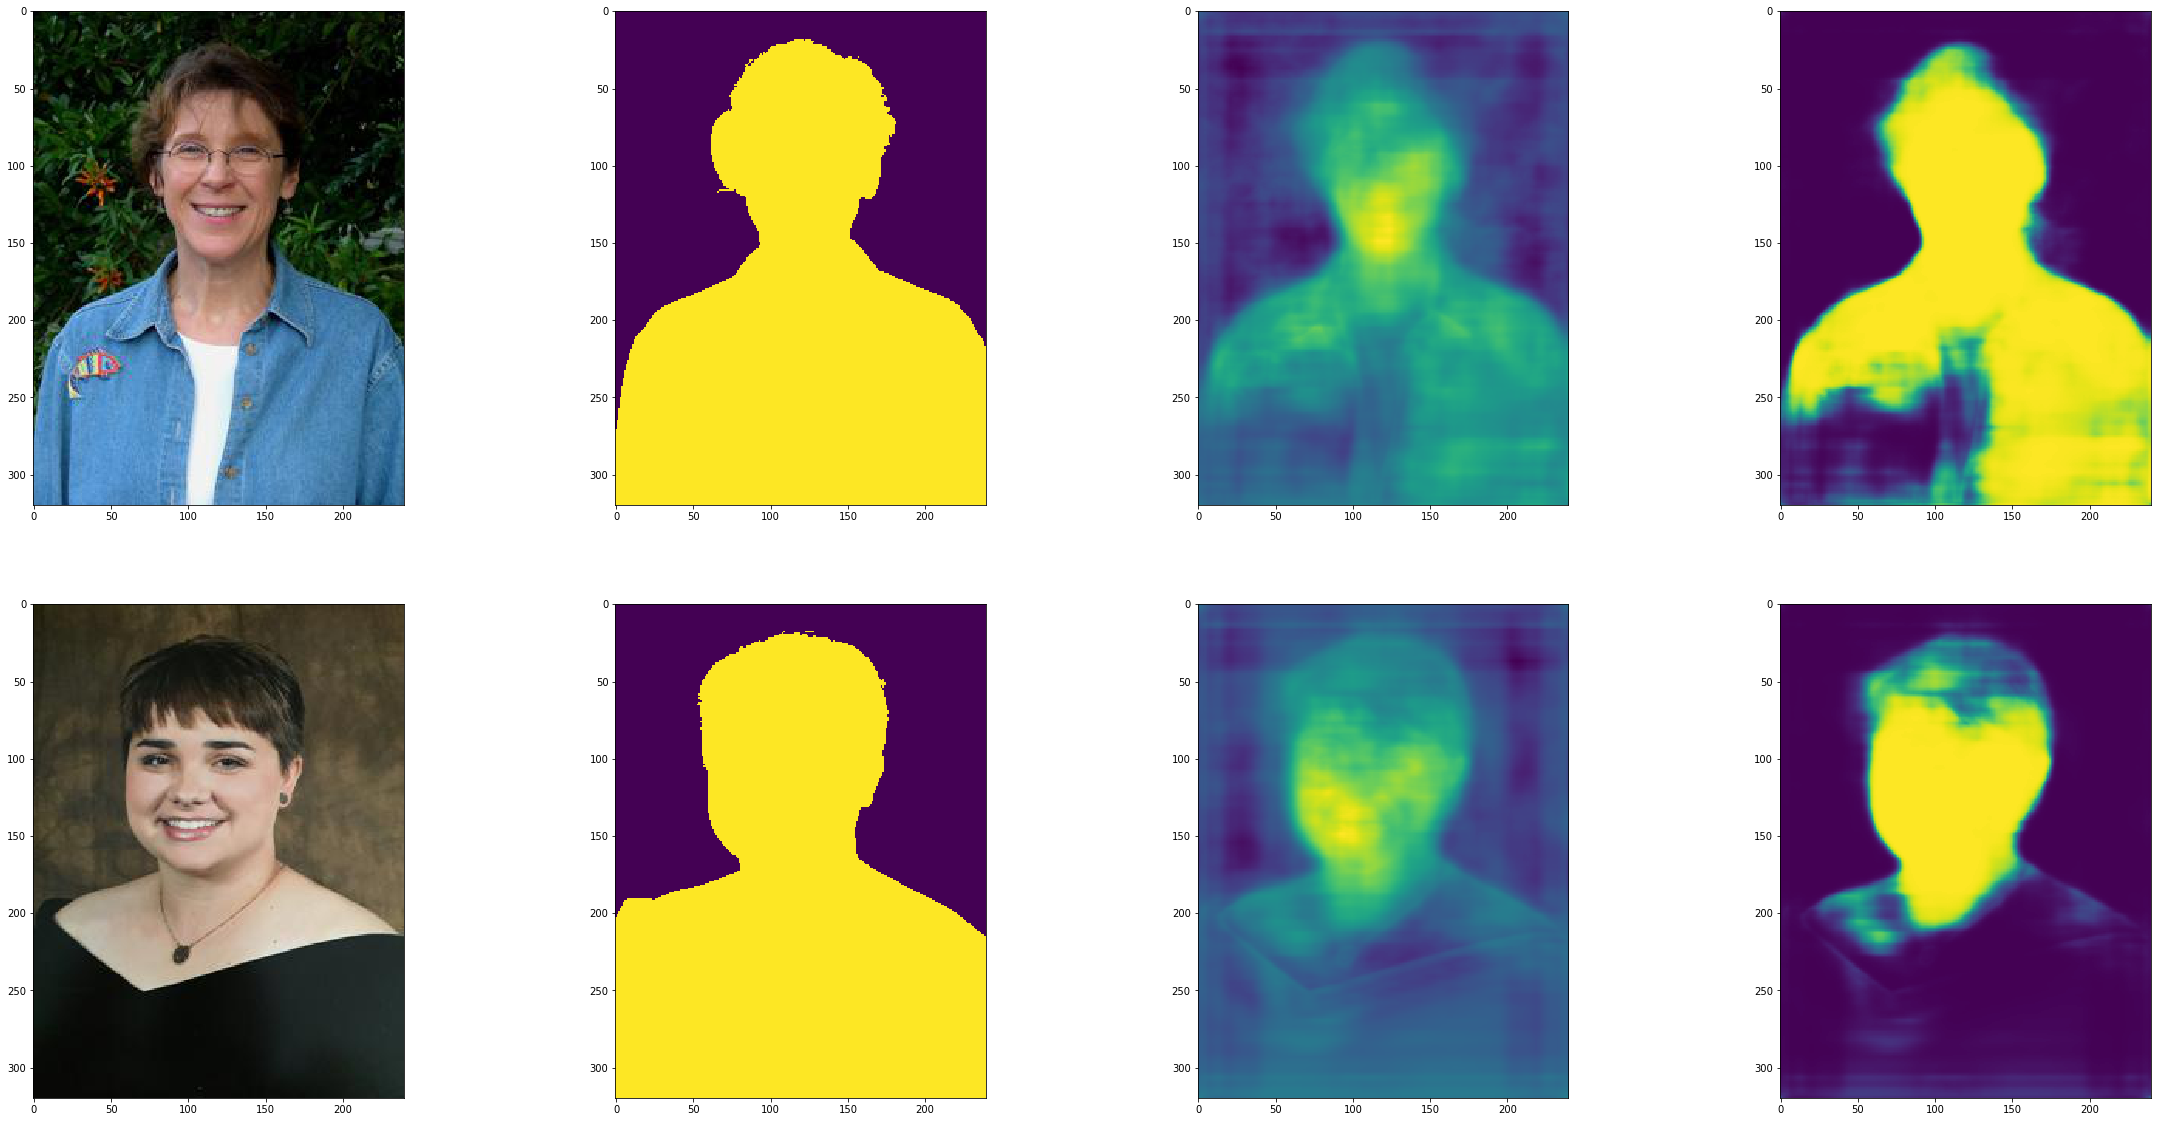

In [53]:
show_net_results(net_LinkNet_BCEDice, dataloader_test)

Обучите LinkNet. Сравните LinkNet и Unet по качеству и скорости работы. Сделайте выводы. 

## Выводы

In [54]:
nets = [
    (net_UNet_BCE, "UNet BCE"), (net_UNet_Dice, "UNet Dice"), (net_UNet_BCEDice, "UNet BCE+Dice"),
    (net_LinkNet_BCE, "LinkNet BCE"), (net_LinkNet_Dice, "LinkNet Dice"), (net_LinkNet_BCEDice, "LinkNet BCE+Dice")
]

losses = pd.DataFrame(columns=['Net Name', 'Dice Loss', 'Cross Entropy Loss'])

for idx, (net, name) in enumerate(nets):
    dice_loss, cross_entropy =  evaluate_net(
        net, dataloader_test, DiceLoss, torch.nn.BCEWithLogitsLoss, device, dtype
    )
    losses.loc[idx] = [name, dice_loss, cross_entropy]
    
losses

Net Name Dice Loss Cross Entropy Loss
0          UNet BCE         0                  1
1         UNet Dice         0                  1
2     UNet BCE+Dice         0                  1
3       LinkNet BCE         0                  1
4      LinkNet Dice         0                  1
5  LinkNet BCE+Dice         0                  1

* Если судить по качеству, то результат модели с Dice Loss устойчиво хуже всех остальных относительно кроссэнтропии. Другие же данные не возможно трактовать из-за их шумности, как следствие, единственный метод для сравнения качества - визуальный.
* Так, например, можно заметить, что при оптимизации Dice Loss Link Net приводит к менее искажённым контурам, чем UNet. Хотя сам по себе Dice Loss приводит к худшим результатам из всех моделей в виду неверного выделения границ, его добавление к кроссэнтропии делает контуры более чёткими, при этом не приводя к их искажению.   
* Что касается времени работы, то Link Net за счёт меньшего числа параметров немного (на 16%) быстрее, чем UNet.

## Бонус: постобработка изображений (1 балл)

В предложенной задаче на фотографиях необходимо сегментировать только центральное изображения. Артефакты, которые появляются на краях изображения, можно удалять с помощью постобработки (например, с помощью модуля https://scikit-image.org/docs/dev/api/skimage.morphology.html). 

Реализуйте какой-нибудь из методов постобработки, дающий прирост в качестве. Продемонстируйте несколько изображений, на которых постобработка будет оказывать влияние на результат сегментации.

## Бонус: существенное улучшение качества (2 балла)

Придумайте какой-нибудь трюк, который существенно (с учётом бонусного пункта 1) повысит качество (которое должно быть и так достаточно высоко). Не разрешается использовать дополнительные данные или другие предобученные кодировщики кроме VGG13.

Если вы что-то попробовали, но качество не повысилось, всё равно оформите этот пункт, даже за неудачные попытки могут быть начислены баллы.